In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
hotels = pd.read_csv('hotels_train.csv')
hotels_test = pd.read_csv('hotels_test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = hotels_test.append(hotels, sort=False).reset_index(drop=True) # объединяем

C:\Users\Dekstop\AppData\Local\Temp\ipykernel_15752\709043790.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = hotels_test.append(hotels, sort=False).reset_index(drop=True) # объединяем


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [5]:
# Списки с признаками непрерывного типа и признаков типа object
print(data.select_dtypes(np.number).columns.to_list())
print(data.select_dtypes('object').columns.to_list())

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score']
['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


In [6]:
print(f'Количество уникальных названий отелей: {data["hotel_name"].nunique()}\n')

# Даты первого и последнего отзывов
data['review_date'] = pd.to_datetime(data['review_date'])
print(f'Первая и последняя даты отзывов:\n{data["review_date"].agg(["min", "max"])}\n')

# Делаем срез и разделяем теги
tags_list = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)
print(f'Количество уникальных тегов: {tags.nunique()}\n')

print(f'Самый частый тег: {tags.mode()[0]}\n')

# С помощью регулярного выражения находим строки с тегом "остановок на ночь"
reg = 'S\w{5}\s\d+\sn\w{4,5}'
night_tags = tags.str.findall(reg).str.get(0)
print(f'Самый частый тег с указанием остановок на ночь: {night_tags.value_counts().index[0]}')

Количество уникальных названий отелей: 1492

Первая и последняя даты отзывов:
min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

Количество уникальных тегов: 2428

Самый частый тег: Leisure trip

Самый частый тег с указанием остановок на ночь: Stayed 1 night


In [7]:
#Чистим от дубликатов
hotels.drop_duplicates(inplace=True)

In [8]:
#Заполняем пустые значения 

import folium
from geopandas.tools import geocode
import numpy as np
from geopy.geocoders import Nominatim #Подключаем библиотеку
geolocator = Nominatim(user_agent="Tester")

address_list = data[data['lat'].isnull()]['hotel_name'].unique().tolist()
df = pd.DataFrame({'hotel_address':address_list})

def get_coords(address, geolocator=geolocator): 
    if geolocator is None:
        geolocator = Nominatim(user_agent="Test")
    ret = geolocator.geocode(address, timeout = 60)
    if ret is None:
        return None
    return ret.latitude, ret.longitude 

# получаем координаты    
df["coords"] = df["hotel_address"].map(get_coords)
df[["lat", "lng"]] = \
    pd.DataFrame(df.pop("coords").tolist(),
                 columns=["lat", "long"], 
                 index=df.index)
    
display(df)

,hotel_address,lat,lng
0,Hotel Atlanta,50.852070,4.354408
1,City Hotel Deutschmeister,NaN,NaN
2,Holiday Inn Paris Montmartre,48.871571,2.343660
3,Fleming s Selection Hotel Wien City,NaN,NaN
4,Hotel City Central,48.213566,16.379921
5,Cordial Theaterhotel Wien,48.209664,16.351426
6,NH Collection Barcelona Podium,41.391882,2.177964
7,Hotel Daniel Vienna,48.188863,16.383852
8,Maison Albar Hotel Paris Op ra Diamond,NaN,NaN
9,Mercure Paris Gare Montparnasse,NaN,NaN


In [9]:
#Переносим предоставленные данные в отдельную переменную и заполняем таблицу известными данными, данные которые не удалось получить заполним модальным значением
coordinates = [(50.852070,4.354408),(48.871571,2.343660),(48.213566,16.379921),(48.213566,16.379921),(48.209664,16.351426),(41.391882,2.177964),(48.188863,16.383852
),(48.219675,16.285496),(41.392715,2.167492),(48.186721,16.420653),(49.136466,9.230946),(27.912454,84.883865 )]

for name,coord in zip(address_list,coordinates):
    hotels.loc[hotels['hotel_name'] == name, ['lat','lng']] = coord[0], coord[1]

In [10]:
import statistics
data['lat'] = data['lat'].fillna(statistics.mode(hotels['lat']))
data['lng'] = data['lng'].fillna(statistics.mode(hotels['lng']))


In [11]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [12]:
#Извлекаем информацию и создаём новые признаки 

import category_encoders as ce

# Редактируем признак тегов для удобства. Создадим столбец с количеством тегов в каждом отзыве
data['tags'] = tags_list
data['tags_cnt'] = tags_list.apply(lambda x: len(x))

# Сохраним топ 10 тегов
top_ten_tags = tags.value_counts().head(10).index.tolist()

# Создадим сигнальные признаки по топ 10 тегам
for tag in top_ten_tags:
    name_f = tag.lower().replace(' ', '_')
    hotels[name_f] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

# Преобразуем столбец с днями проверки отзывов
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

# Извлечем из даты возраст отзыва, год, месяц и день недели
data['review_age'] = (pd.to_datetime('today') - data['review_date']).dt.days
data['day_of_week'] = data['review_date'].dt.weekday
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year
# закодируем год
or_code = ce.OrdinalEncoder(cols=['year'])
data['year_code'] = or_code.fit_transform(data[['year']])

# Создаём списки с отсутствием позитивных и отсутствием негативных отзывов
no_negative_list = [
    'No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None', ' ', ' N a', ' All good', ' Nothing really',
    ' none', ' nothing ', ' No complaints', ' Nil', ' Nothing really ', ' No', ' Nothing to dislike ',
    ' Everything was perfect ', ' Everything was great ', ' Everything was perfect', ' Absolutely nothing ', ' None ',
    ' No complaints ', ' All good ', ' NA', ' n a', ' Nothing to dislike', ' Nothing at all', ' Nothing at all '
]
no_positive_list = ['No Positive', ' Nothing', ' Nothing ', ' nothing', ' ']

# Сигнальные признаки отсутсвия негативных и отсутвия позитивных отзывов
data['negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_list else 1)
data['positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_list else 1)

# Извлекаем название страны из адреса и создаём признаки с помощью однократного кодирования
data['hotel_address'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data = pd.get_dummies(data, columns=['hotel_address'], prefix='country')

# Кодируем названия отелей и национальность ревьюера посредсвом бинарного кодирования
bincode = ce.BinaryEncoder(cols=['hotel_name', 'reviewer_nationality'])
n_n_code = bincode.fit_transform(data[['hotel_name', 'reviewer_nationality']])
data = pd.concat([data, n_n_code], axis=1)

# Удаляем все обработанные столбцы типа object
# Удаляем все обработанные столбцы типа object
data = data.drop(
    ['tags', 'negative_review', 'positive_review', 'hotel_name', 'reviewer_nationality', 'review_date'], axis=1)

In [13]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

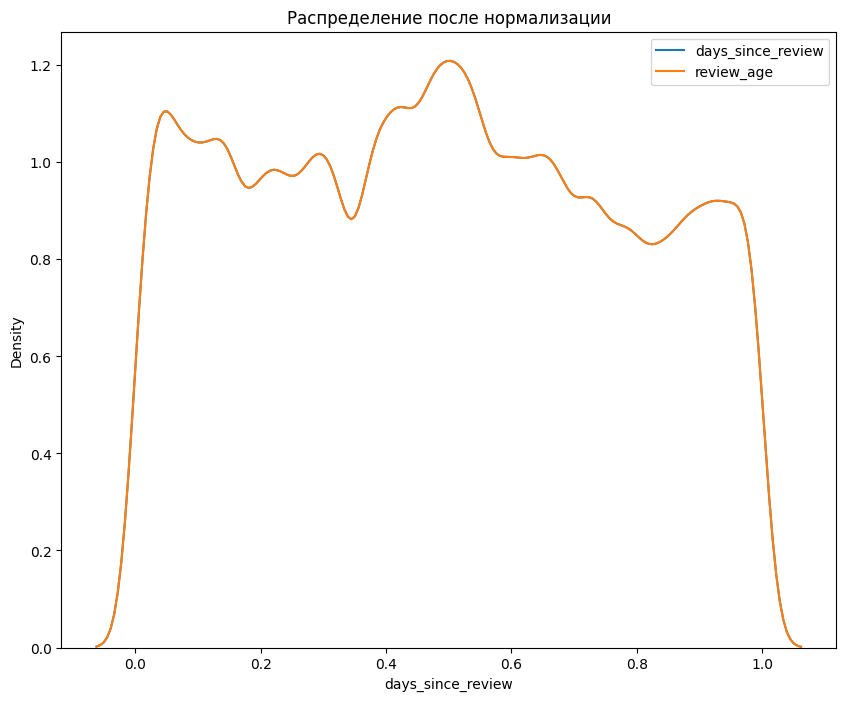

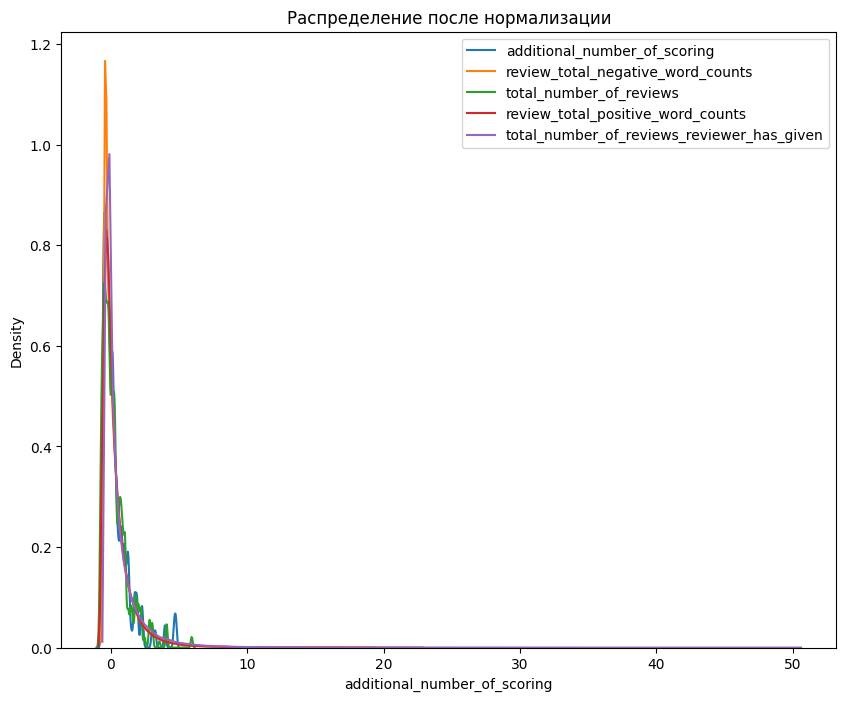

In [14]:
#Нормализация данных

from sklearn import preprocessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Колонны без выбросов
col_list = data[['days_since_review', 'review_age']].columns.tolist()

# Список с колоннами имеющие выбросы
outliers_col = data[['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
      'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']].columns.tolist()

# Нормализуем колонны без выбрасов
mm_scal = preprocessing.MinMaxScaler()
data[col_list] = mm_scal.fit_transform(data[col_list])

# Смотрим на распределение
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации')
for col in col_list:
       sns.kdeplot(data[col], ax=ax1, label=col)
plt.legend();

# Нориализуем колонны с выбросами
r_scal = preprocessing.RobustScaler()
data[outliers_col] = r_scal.fit_transform(data[outliers_col])

# Строим распределение
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации')
for col in outliers_col:
       sns.kdeplot(data[col], ax=ax1, label=col)
plt.legend();

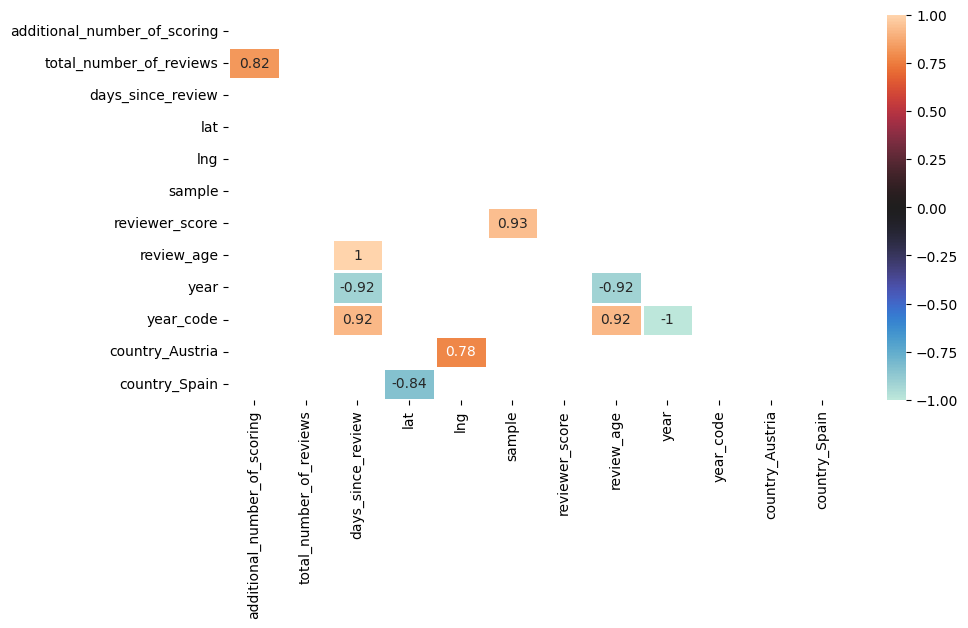

In [15]:
#Отбираем признаки

# Построим корреляцию и отфильтруем по очень сильной взаимосвязи
df_corr = data.corr()
df_corr = df_corr[(df_corr < 1) & (abs(df_corr) > 0.7)]
df_corr = df_corr.dropna(thresh=1, axis=0)
df_corr = df_corr.dropna(thresh=1, axis=1)
matrix = np.triu(df_corr)

# Визуализируем матрицу корреляции
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(df_corr, annot=True, ax=ax, mask=matrix, linewidths=1, center=0, vmin=-1);


In [16]:
# Удалим мультиколлинеальные признаки
data = data.drop([ 'country_Austria', 'additional_number_of_scoring', 'year_code',
    'country_Spain',  'year', 'days_since_review'
], axis=1)

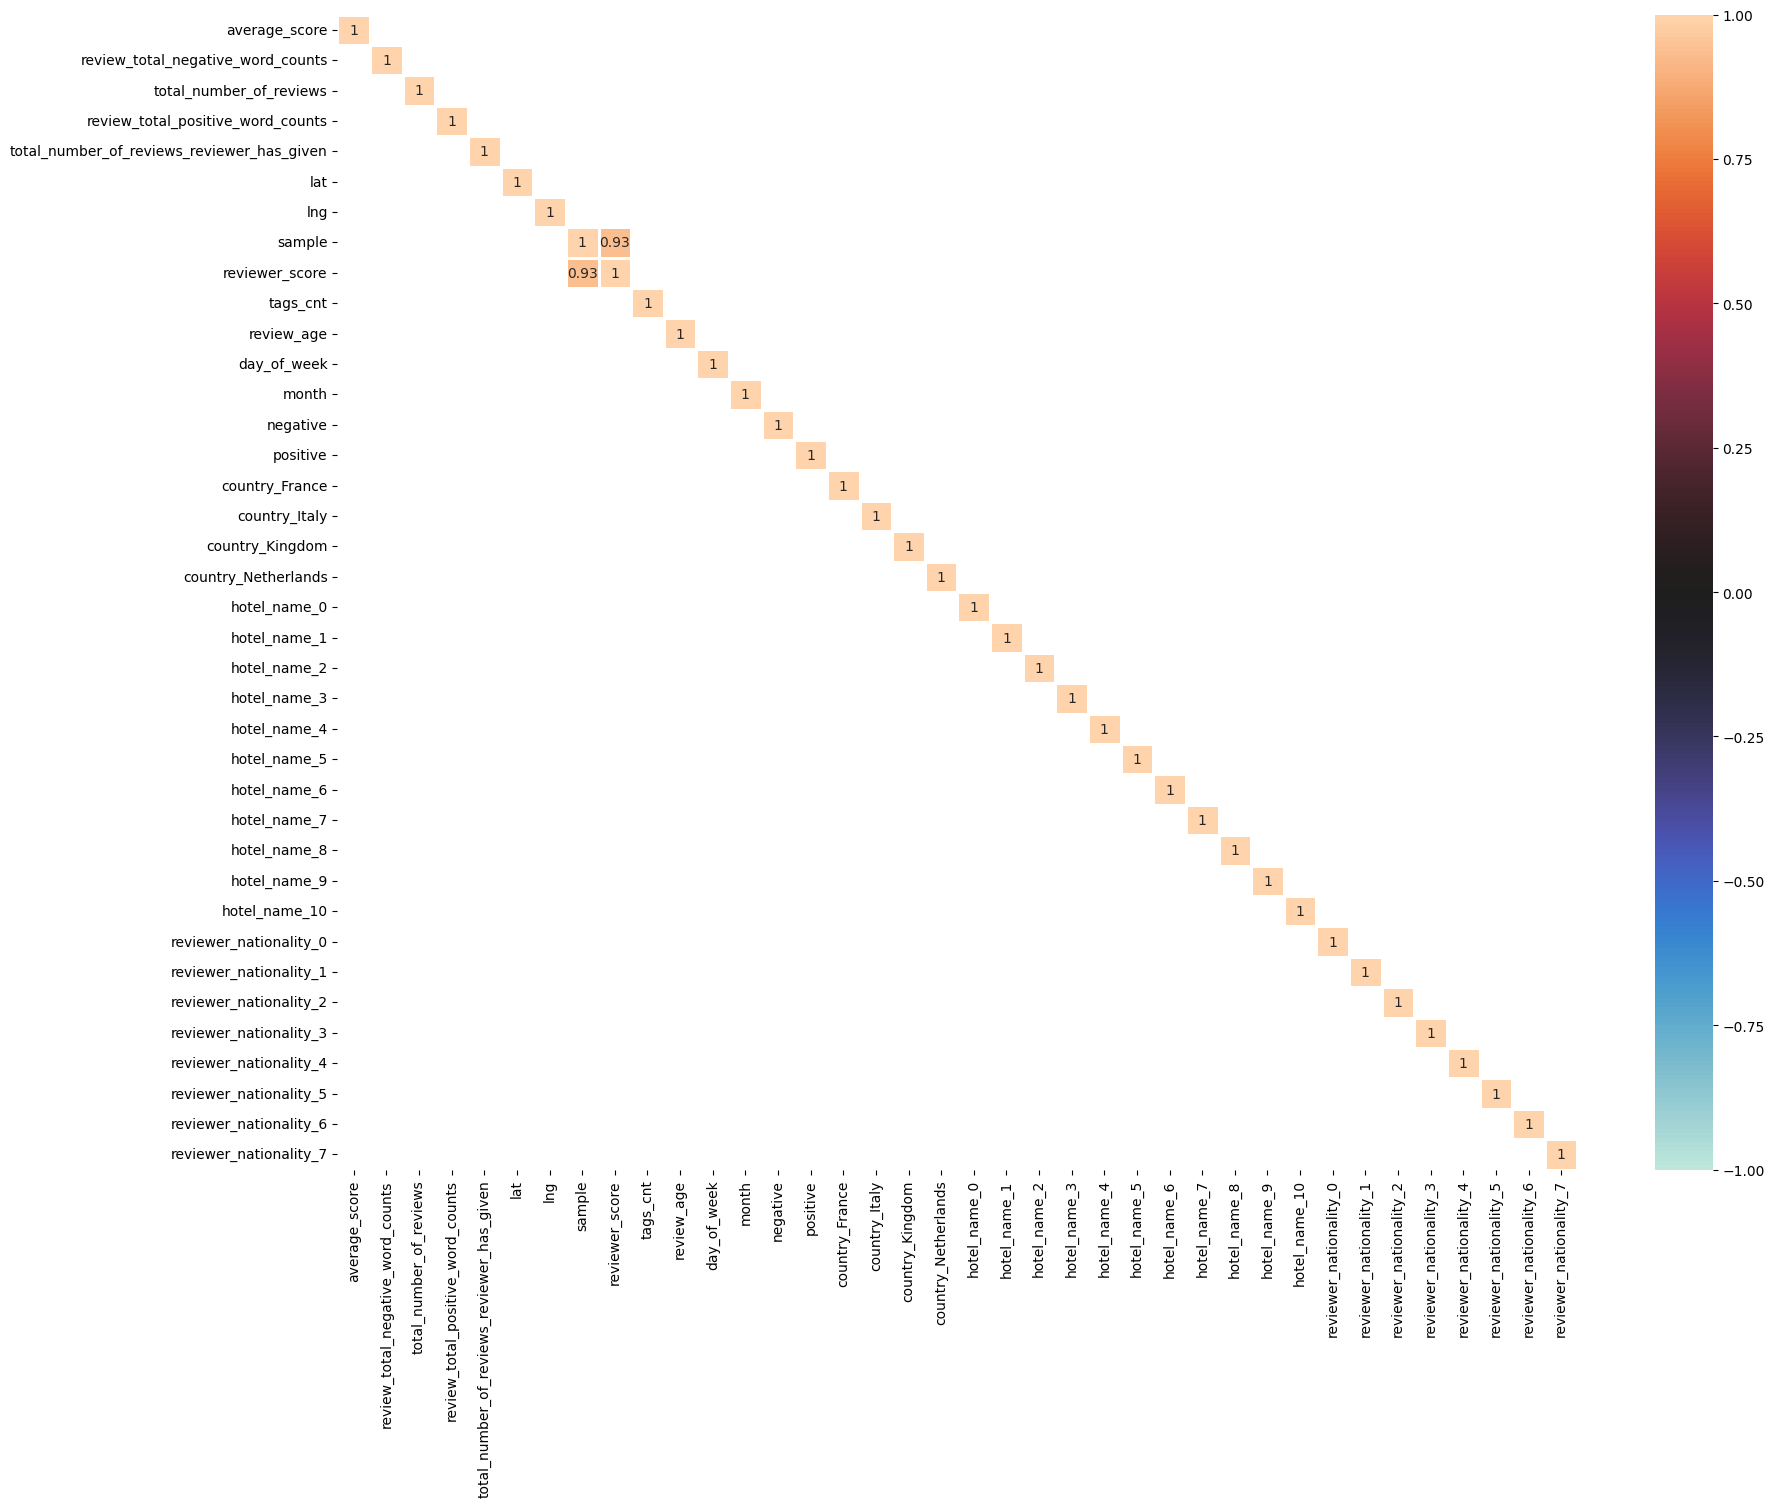

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mask = np.array(abs(data.corr()) < 0.7)
sns.heatmap(data.corr(), annot=True, ax=ax, center=0, vmin=-1, linewidths=1, mask=mask);

Машинный код

In [18]:
seed = 42
!pip freeze > requirements.txt

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели.
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)
y = train_data['reviewer_score']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=seed)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.1336131231743935


In [20]:
# Выполняем предсказание на тестовых данных.
predict_submission = regr.predict(test_data)

# Подставим результат
submission['reviewer_score'] = predict_submission

# Сохраним полученные данные и сделаем сабмит.
submission.to_csv('my_submission.csv', index=False)